In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from cmocean import cm
from matplotlib.colors import LinearSegmentedColormap
from airsea.windstress import stress
from matplotlib import mlab
import scipy.signal as signal
import scipy.stats as st
from scipy.interpolate import interp1d
from scipy import arange, array, exp, integrate
from physoce import tseries as ts
import gsw

def neureg(x,y):
    #x,y are numpy arrays
    #subtract mean to make zero mean:
    xn = x - np.mean(x)
    yn = y - np.mean(y)
    #perform neutral regression for comparison, e.g. Garrett and Petrie 1981 and Kirincich et al 2005
    an = np.sqrt(((st.tvar(yn)))/((st.tvar(xn)))) #find slope
    bn = (np.mean(y) - an*np.mean(x)) #find intercept
    rn = np.sum(x*y)/np.sqrt((np.sum(x**2)*np.sum(y**2))) #find correlation coefficient
    slope_err = an*np.sqrt((1-rn**2)/len(x)) #compute std err in slope = a*sqrt((1-r^2)/n)
    #compute std err in intercept = vary^.5*sqrt((1-r^2)/n*(1+xmean^2/var(x))) 
    #(e.g., Miller & Kahn 1962, Statistical Analysis in the Geological Science)
    #https://stats.stackexchange.com/questions/391112/standard-error-of-coefficient-estimates-for-model-ii-regression
    inter_err = np.sqrt(st.tvar(yn))*np.sqrt(((1-rn**2)/len(x))*(1+np.mean(x)**2/st.tvar(xn))) 
    return an,bn,rn,slope_err,inter_err

def extrap1d(interpolator):
    xs = interpolator.x
    ys = interpolator.y

    def pointwise(x):
        if x < xs[0]:
            return ys[0]+(x-xs[0])*(ys[1]-ys[0])/(xs[1]-xs[0])
        elif x > xs[-1]:
            return ys[-1]+(x-xs[-1])*(ys[-1]-ys[-2])/(xs[-1]-xs[-2])
        else:
            return interpolator(x)

    def ufunclike(xs):
        return np.array(list(map(pointwise, np.array(xs))))

    return ufunclike

def rot(u,v,theta):
    w = u + 1j*v
    ang = theta*np.pi/180
    wr = w*np.exp(1j*ang)
    ur = np.real(wr)
    vr = np.imag(wr)
    return ur,vr

def princax(u,v=None):

    # if one input only, decompose complex vector
    if v is None:
        w = np.copy(u)
        u = np.real(w)
        v = np.imag(w)

    # only use finite values for covariance matrix
    ii = np.isfinite(u+v)
    uf = u[ii]
    vf = v[ii]

    # compute covariance matrix
    C = np.cov(uf,vf)

    # calculate principal axis angle (ET, Equation 4.3.23b)
    theta = 0.5*np.arctan2(2.*C[0,1],(C[0,0] - C[1,1])) * 180/np.pi

    # calculate variance along major and minor axes (Equation 4.3.24)
    term1 = C[0,0] + C[1,1]
    term2 = ((C[0,0] - C[1,1])**2 + 4*(C[0,1]**2))**0.5
    major = np.sqrt(0.5*(term1 + term2))
    minor = np.sqrt(0.5*(term1 - term2))

    return theta,major,minor

In [65]:
ds = xr.open_dataset('C:/Users/asche/REU21/netcdf/inshore_surface_adcp_comb_v2.nc')
zero = np.zeros(len(ds['time']))

In [61]:
ncfile_prof = 'http://thredds.dataexplorer.oceanobservatories.org/thredds/dodsC/ooigoldcopy/public/CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered/deployment0013_CE01ISSP-SP001-06-NUTNRJ000-recovered_cspp-nutnr_j_cspp_instrument_recovered.ncml'
ds_no3 = xr.open_dataset(ncfile_prof+'#fillmismatch')

In [62]:
ds_no3 = ds_no3.swap_dims({'obs':'time'})

In [63]:
ds_no3.load()

<xarray.Dataset>
Dimensions:                                 (time: 14288, wavelength: 256)
Coordinates:
  * wavelength                              (wavelength) int32 0 1 2 ... 254 255
    obs                                     (time) int32 0 1 2 ... 14286 14287
  * time                                    (time) datetime64[ns] 2019-05-29T...
    pressure                                (time) float64 18.85 ... 0.9342
    lat                                     (time) float64 44.66 44.66 ... 44.66
    lon                                     (time) float64 -124.1 ... -124.1
Data variables: (12/56)
    profiler_timestamp                      (time) datetime64[ns] 2019-05-29T...
    nutnr_spectrum_average                  (time) float32 1.82e+04 ... 1.708...
    nutnr_fit_base_2                        (time) float32 -1.738 ... -2.3
    nutnr_fit_base_1                        (time) float32 5.111 4.71 ... 9.646
    year                                    (time) float32 2.019e+03 ... 2.01...
    ctd_psu                                 (time) float32 -1.0 -1.0 ... -1.0
    ...                                      ...
    ctd_temp_qc_results                     (time) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_executed                    (time) float32 1.0 1.0 ... 1.0 1.0
    ctd_dbar_qc_results                     (time) float32 0.0 0.0 ... 0.0 0.0
    salinity_corrected_nitrate_qc_executed  (time) float32 29.0 29.0 ... 29.0
    salinity_corrected_nitrate_qc_results   (time) float32 13.0 13.0 ... 29.0
    spectral_channels                       (time, wavelength) float32 593.0 ...
Attributes: (12/70)
    node:                               SP001
    comment:                            
    publisher_email:                    
    sourceUrl:                          http://oceanobservatories.org/
    collection_method:                  recovered_cspp
    stream:                             nutnr_j_cspp_instrument_recovered
    ...                                 ...
    geospatial_lon_resolution:          0.1
    geospatial_vertical_units:          meters
    geospatial_vertical_resolution:     0.1
    geospatial_vertical_positive:       down
    DODS.strlen:                        18
    DODS.dimName:                       string18

In [66]:
ds.load()

<xarray.Dataset>
Dimensions:           (bin_depths_avg: 22, time: 2235)
Coordinates:
  * time              (time) datetime64[ns] 2019-04-20T03:30:00 ... 2019-10-2...
  * bin_depths_avg    (bin_depths_avg) float64 -21.98 -20.98 ... -1.98 -0.9797
Data variables: (12/16)
    u                 (bin_depths_avg, time) float64 0.0781 0.1144 ... 1.195
    v                 (bin_depths_avg, time) float64 0.08675 0.1102 ... -0.2696
    sea_surface       (time) float64 -1.069 -0.4755 0.8208 ... 0.5014 0.2247
    bottom_depth_avg  float64 24.08
    u_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    v_fil             (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    ...                ...
    cs_fil            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    as_fil            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    cs_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    as_bar            (bin_depths_avg, time) float64 nan nan nan ... nan nan nan
    us_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan
    zs_comb           (time) float64 nan nan nan nan nan ... nan nan nan nan nan

In [67]:
dt_str = '0.5H'  # string indicating time averaging frequency
dt = pd.to_timedelta(dt_str)   # time averaging frequency as timedelta
tmin = ds_no3['time'][0].dt.round(dt_str)    # round start date
tmax = ds_no3['time'][-1].dt.round(dt_str)   # round end date
time_grid = ds['time'].values   # array of dates

In [68]:
good_bin = (ds['bin_depths_avg'] < 0)
pmin = 0  # minimum pressure
pmax = np.max(ds_no3['pressure'])   # maximum pressure
dp = 1   # pressure averaging interval
pressure_grid = np.flip(-ds['bin_depths_avg'].values) # center of pressure bins
pressure_bins = np.zeros(len(pressure_grid)+1) # edges of pressure bins
pressure_bins[0] = pressure_grid[0] - dp/2
pressure_bins[-1] = pressure_grid[-1] + dp/2
for i in range(len(pressure_bins)-2):
    pressure_bins[i+1] = np.average([pressure_grid[i],pressure_grid[i+1]])
#for i in range(len(pressure_bins)-1):
#    pressure_grid.append(np.average([pressure_bins[i],pressure_bins[i+1]]))  # center of pressure bins
#pressure_grid = np.array(pressure_grid))


In [69]:
pressure_bins

array([ 0.47974168,  1.47974168,  2.47974168,  3.47974168,  4.47974168,
        5.47974168,  6.47974168,  7.47974168,  8.47974168,  9.47974168,
       10.47974168, 11.47974168, 12.47974168, 13.47974168, 14.47974168,
       15.47974168, 16.47974168, 17.47974168, 18.47974168, 19.47974168,
       20.47974168, 21.47974168, 22.47974168])

In [70]:
pressure_grid

array([ 0.97974168,  1.97974168,  2.97974168,  3.97974168,  4.97974168,
        5.97974168,  6.97974168,  7.97974168,  8.97974168,  9.97974168,
       10.97974168, 11.97974168, 12.97974168, 13.97974168, 14.97974168,
       15.97974168, 16.97974168, 17.97974168, 18.97974168, 19.97974168,
       20.97974168, 21.97974168])

In [71]:
# pre-allocate gridded variable with NaNs
#temperature_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])
nitrate_grid = np.nan*np.empty([len(time_grid),len(pressure_grid)])

In [109]:
for i,t in enumerate(time_grid):
    # find dates that fall in interval
    try:
        #ignores final 
        ti, = np.where((ds_no3['time'] >= time_grid[i]) & (ds_no3['time'] < time_grid[i+1]))
        nitrate_subset = ds_no3['nitrate_concentration'].isel(time=ti) 
        #print(t)
        #print(ti)
        nitrate_binned = nitrate_subset.groupby_bins('pressure',pressure_bins).mean()
        nitrate_grid[i,:] = nitrate_binned.values
    except:
        pass

In [110]:
len(nitrate_grid.T)

22

In [111]:
cs_bar = np.array(ds['cs_bar'].values.T)
len(cs_bar.T)

22

In [112]:
nflux = np.nan*np.empty([len(nitrate_grid),len(nitrate_grid.T)])

In [113]:
dz = np.nan*np.empty(len(pressure_grid))
for i,pg in enumerate(pressure_grid):
    dz[i] = pressure_bins[i+1] - pressure_bins[i] #find height of each bin
dz

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.])

In [114]:
for i in range(len(nitrate_grid)):
    for j in range(len(nitrate_grid.T)):
        #leave nan values as nan in case they do not match up b/t cs and nit
        #if not np.isnan(nitrate_grid[i][j]) & np.isnan(cs_bar[i][j]):
            #nitrate flux in mmol/s/meter coastline
        nflux[i][j] = nitrate_grid[i][j] * cs_bar[i][j] * dz[j]

In [149]:
mask = ~np.isnan(nflux.T)
zeros = np.zeros(len(time_grid))
t1 = np.datetime64('2019-06-01 00:00:00')
t2 = np.datetime64('2019-08-01 00:00:00')

Text(0, 0.5, 'Nitrate Concentration [$mmol/m^3$]')

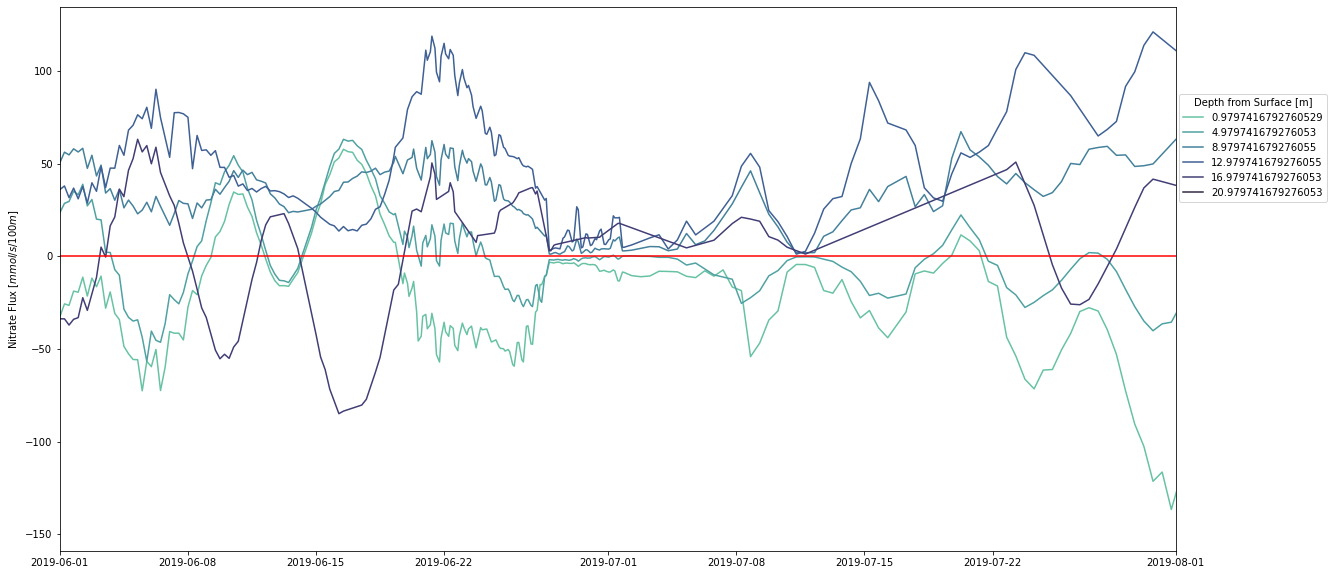

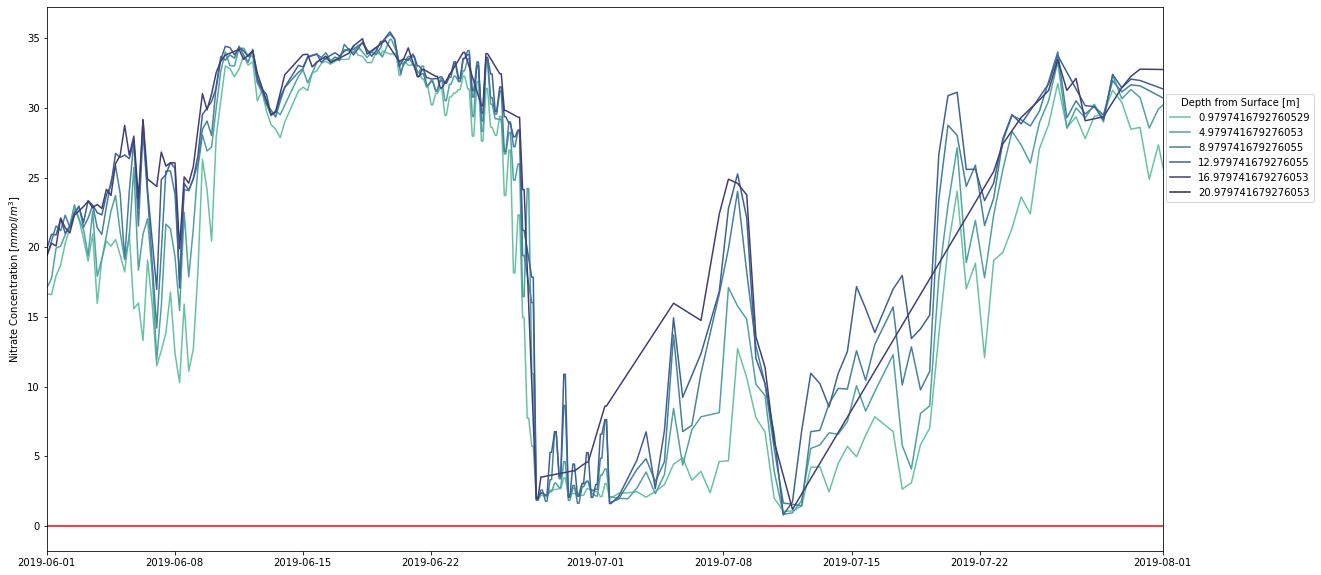

In [198]:
plt.figure(figsize=(20,10))

cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,nf in enumerate(nflux.T):
    nfline.append('')
    if i%4 == 0:
        nfline[i], = plt.plot(time_grid[mask[i]],nf[mask[i]]*100,'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [m]',bbox_to_anchor=(1.14,.85), loc=1)
plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylabel('Nitrate Flux [$mmol/s/100m$]')

plt.figure(figsize=(20,10))

cdict = cm.tools.get_dict(cm.deep, N=len(nitrate_grid.T))
deep = LinearSegmentedColormap('cmap', cdict)
nfline = []
for i,n in enumerate(nitrate_grid.T):
    nfline.append('')
    if i%4 == 0:
        nfline[i], = plt.plot(time_grid[mask[i]],n[mask[i]],'-',color=deep(0.3+0.7*i/len(nflux.T)),label=pressure_grid[i])
plt.legend(title='Depth from Surface [m]',bbox_to_anchor=(1.14,.85), loc=1)
plt.plot(time_grid,zeros,'r')
plt.xlim([t1,t2])
plt.ylabel('Nitrate Concentration [$mmol/m^3$]')

In [194]:
surface_flux = np.zeros(len(time_grid))
bottom_flux = np.zeros(len(time_grid))

for i,t in enumerate(time_grid):
    for j,nf in enumerate(nflux[i]):
        if ~np.isnan(nf):
            if pressure_grid[j] <= -ds['zs_comb'].values[i]:
                surface_flux[i] += nf
            elif pressure_grid[j] > -ds['zs_comb'].values[i]:
                bottom_flux[i] += nf

delta_flux = surface_flux+bottom_flux

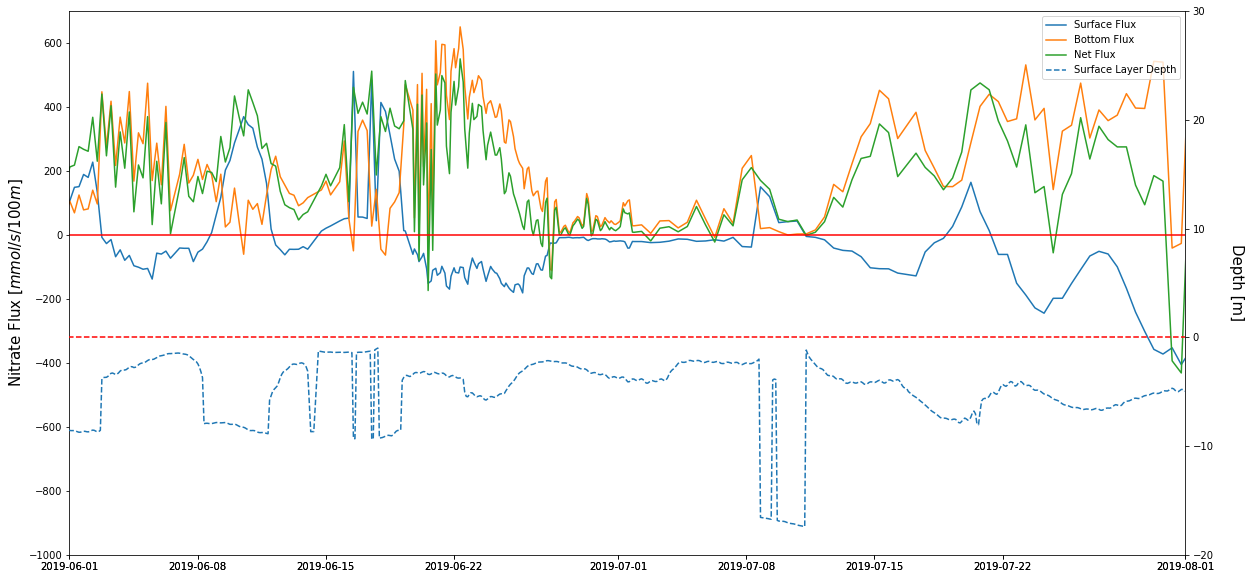

In [231]:
surf_mask = np.where(surface_flux != 0)
bott_mask = np.where(bottom_flux != 0)
zs_mask = ~np.isnan(ds['zs_comb'])

nflux_label = [None]*4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Depth [m]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[surf_mask],bottom_flux[surf_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[surf_mask],delta_flux[surf_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['zs_comb'].values[zs_mask],'--',label='Surface Layer Depth')
ax2.plot(time_grid,zeros,'r--')
plt.xlim([t1,t2])
ax1.set_ylim([-1000,700])
ax2.set_ylim([-20,30])
plt.legend(handles=nflux_label)

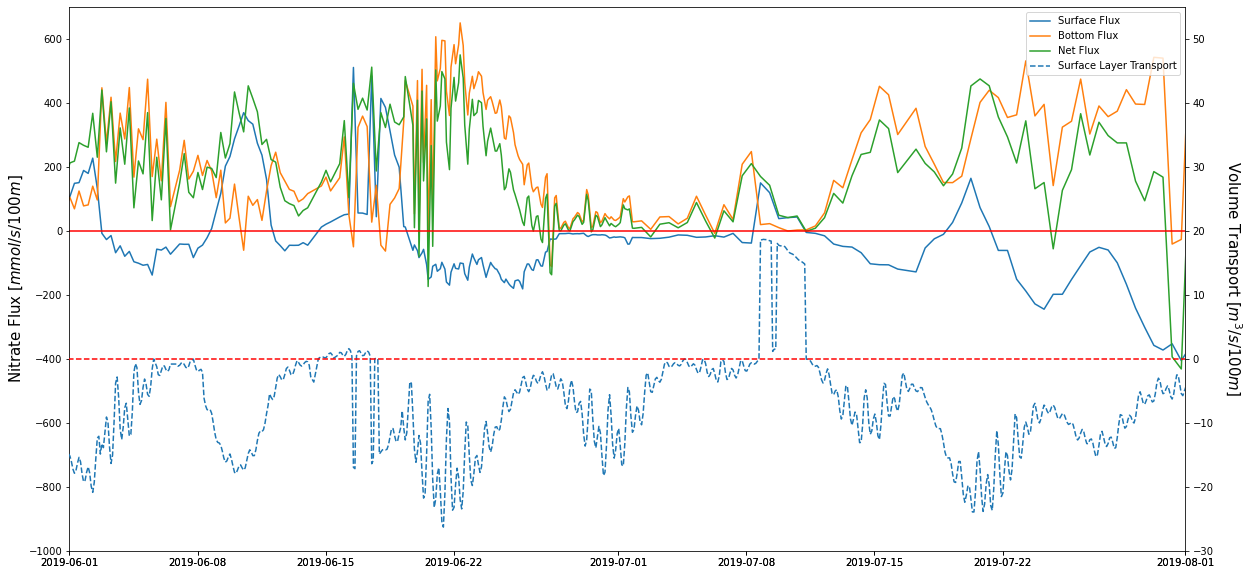

In [236]:
us_mask = ~np.isnan(ds['us_comb'])

nflux_label = [None]*4
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(111)
ax1.set_ylabel("Nitrate Flux [$mmol/s/100m$]", fontsize=15)
ax2 = fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
ax2.set_ylabel("Volume Transport [$m^3/s/100m$]", rotation=270, labelpad=30, fontsize=15)
nflux_label[0], = (ax1.plot(time_grid[surf_mask],surface_flux[surf_mask]*100,label='Surface Flux'))
nflux_label[1], = (ax1.plot(time_grid[surf_mask],bottom_flux[surf_mask]*100,label='Bottom Flux'))
nflux_label[2], = (ax1.plot(time_grid[surf_mask],delta_flux[surf_mask]*100,label='Net Flux'))
ax1.plot(time_grid,zeros,'r')
nflux_label[3], = ax2.plot(time_grid[zs_mask],ds['us_comb'].values[zs_mask]*100,'--',label='Surface Layer Transport')
ax2.plot(time_grid,zeros,'r--')
plt.xlim([t1,t2])
ax1.set_ylim([-1000,700])
ax2.set_ylim([-30,55])
plt.legend(handles=nflux_label)